# MegaMart Customer Segmentation Analysis
This analysis is made by Team 6, consisting of Sofia Knutas (A01831481) & Kristina Stapnes (A01830792). 
Course: Aplicación de métodos multivariados en ciencia de datos (Gpo 601)


## Section 1: Project Setup & Data Loading

In [61]:
# Import all libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)


logger.info("Libraries imported successfully")

INFO: Libraries imported successfully


In [2]:
# Load dataset
dir = Path.cwd()
csv_file = dir / "retail_customer_data-1.csv"

df = pd.read_csv(csv_file)
logger.info(f"Loaded {len(df)} customer records")

INFO: Loaded 3000 customer records


In [3]:
# Initial inspection of the dataset 
df.head()

,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18


In [4]:
df.tail()

,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
2995,CUST_2996,2.5,3.4,361.24,44.9,0.95,24.7,0.34,7,29
2996,CUST_2997,8.9,6.6,1267.59,34.4,0.00,40.1,0.04,15,18
2997,CUST_2998,4.4,2.9,1004.42,18.9,0.00,31.0,0.24,2,13
2998,CUST_2999,8.1,5.9,1143.57,26.6,0.00,37.2,0.07,8,17
2999,CUST_3000,7.5,6.1,1241.33,28.4,0.00,34.0,0.25,14,18


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.011300,9.485133,2367.375387,38.441533,0.443720,31.359467,0.185890,17.912667,20.680667
std,4.776564,7.961280,2248.271454,14.334159,0.427384,9.964088,0.162283,11.242294,12.055419
min,0.200000,1.000000,50.000000,3.400000,0.000000,3.000000,0.000000,1.000000,1.000000
25%,2.100000,3.300000,511.115000,27.000000,0.000000,24.900000,0.040000,9.000000,11.000000
50%,5.000000,5.600000,1456.105000,36.550000,0.340000,31.600000,0.150000,18.000000,18.000000
75%,8.800000,17.325000,3772.227500,49.400000,0.950000,37.800000,0.290000,26.000000,29.250000
max,22.300000,31.600000,8746.290000,87.300000,0.950000,62.400000,0.500000,59.000000,67.000000


### Initial Findings
From just inspecting the dataset we can see that there is 3000 entries in total, all of them are non-null for each variable. There are 10 variables, one of them is an identification variable (cutomer_id), whereas the other nine are behavioral variables.

## Section 2: Exploratory Data Analysis (EDA)

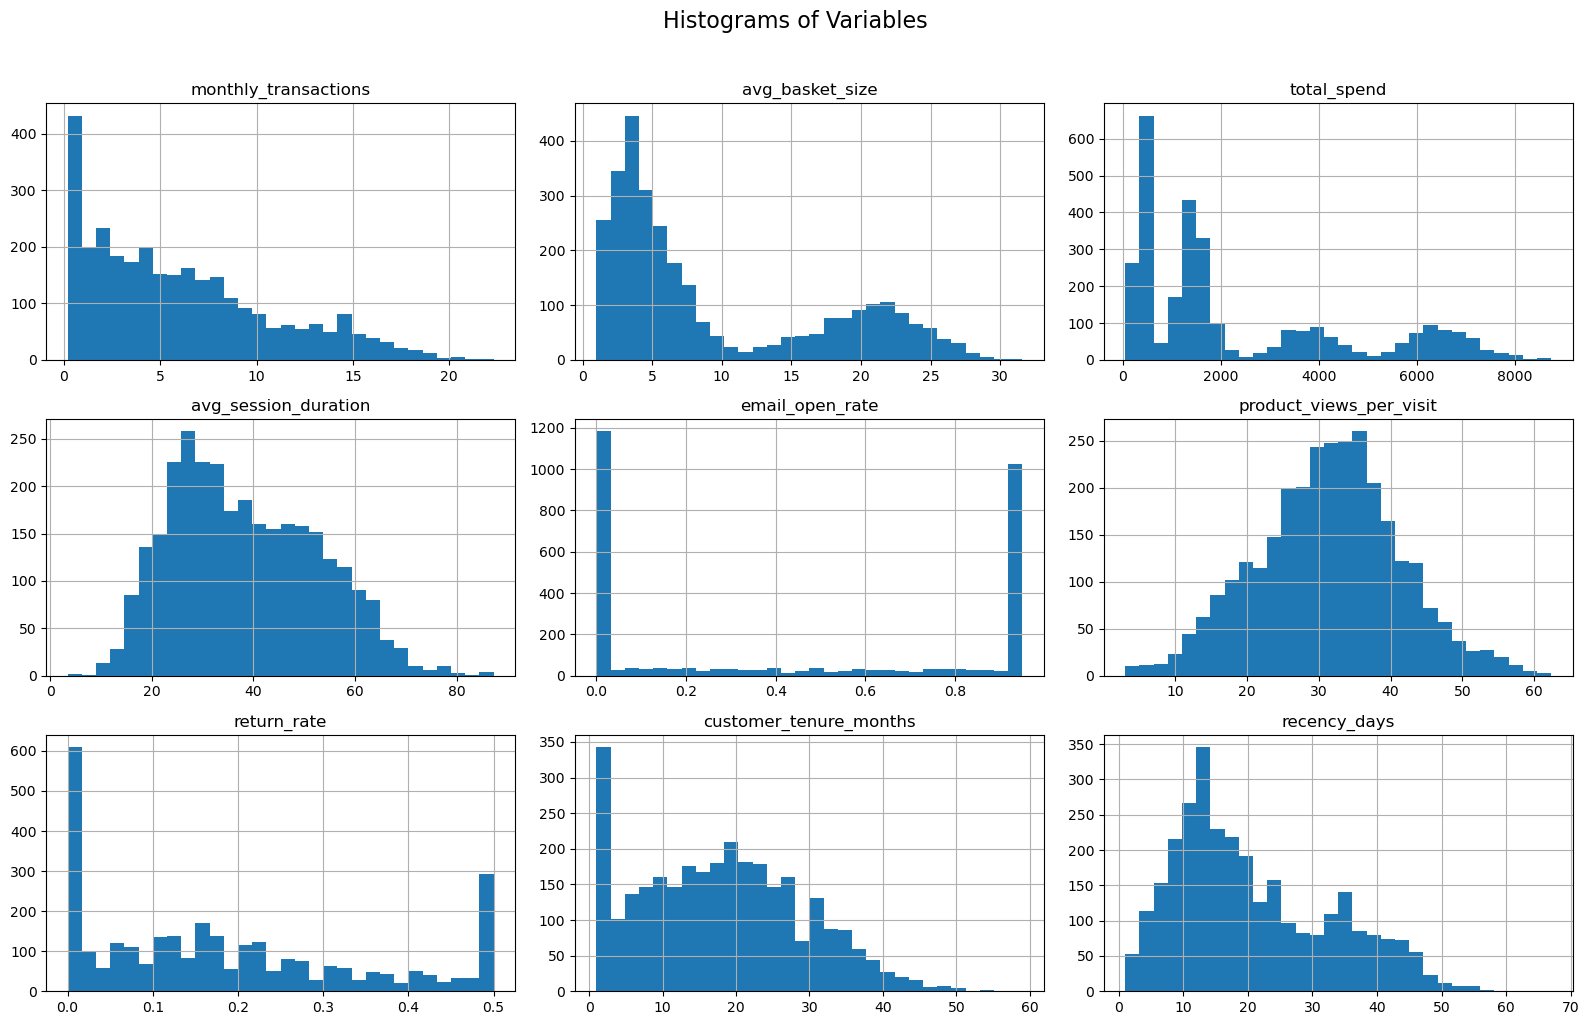

In [7]:
# Histograms for all behavioral variables
df.hist(bins=30, figsize=(16, 10))
plt.suptitle("Histograms of Variables", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

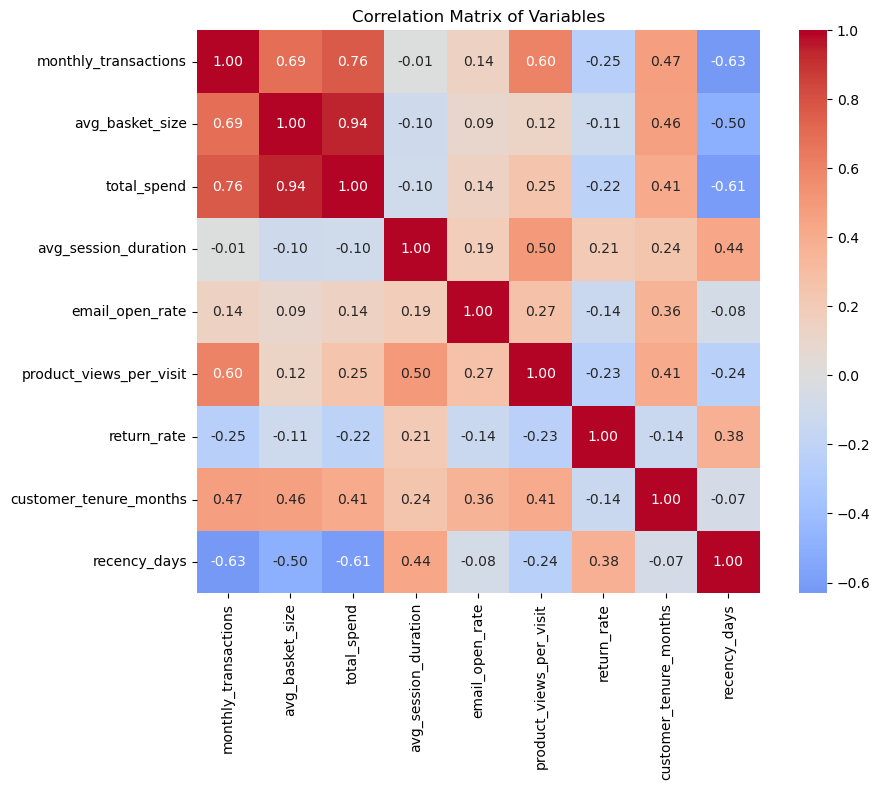

In [12]:
# Correlation matrix heatmaps
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Correlation Matrix of Variables")
plt.tight_layout()
plt.show()

In the correlation heatmap we can see that the variables total_spend and avg_basket_size has the highest correlation of 0.94m which is a exceptionally high result. Furthermore, monthly_transactions and total_spend have also have high correlation of 0.76. Therafter comes monthly_transactions and avg_basket_size with their correlation of 0.69. From this we can conclude that the three varaibles monthly_transactions, total_spend and avg_basket_size, are all three very correlated. The only other pair with correlation over 0.5 is monthly_transactions and product_views_per _visit. 

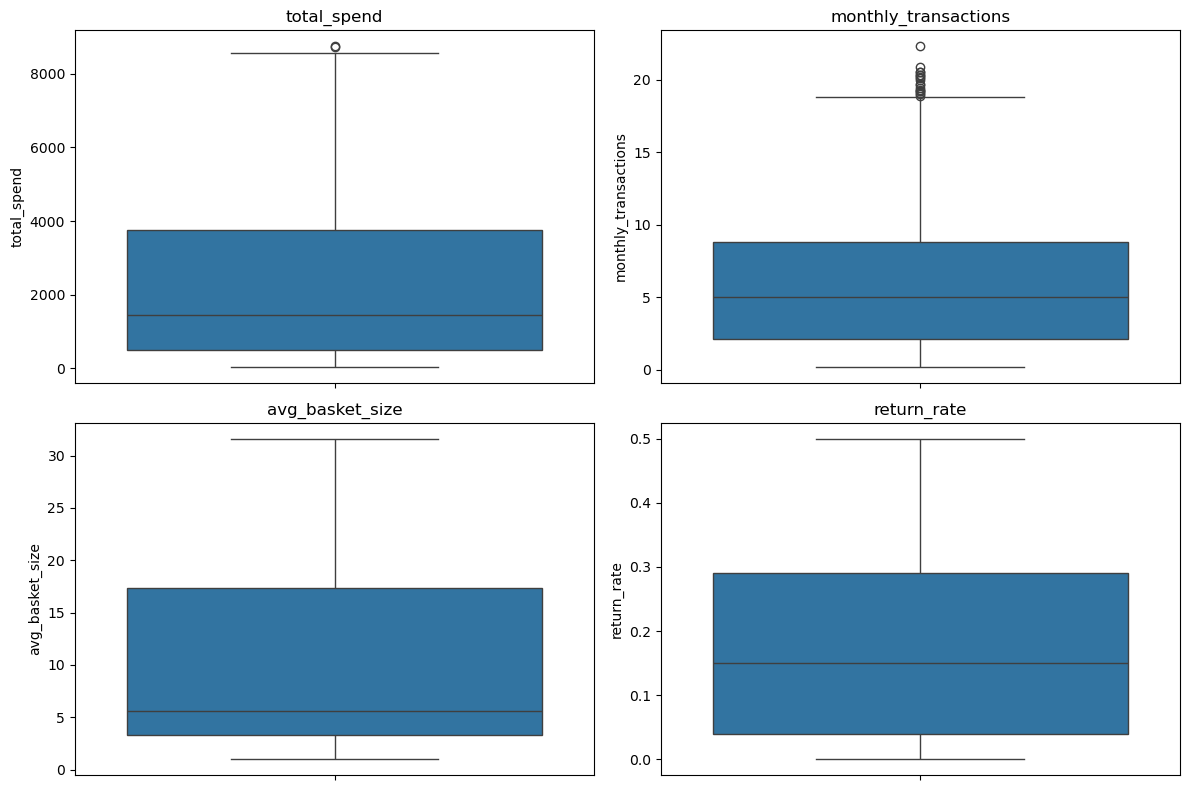

=== Outlier (IQR Method) ===
total_spend: 2 outliers
monthly_transactions: 18 outliers
avg_basket_size: 0 outliers
return_rate: 0 outliers


In [24]:
# Outlier detection
key_vars = ["total_spend", "monthly_transactions", "avg_basket_size", "return_rate"]
n_cols = 2
n_rows = int(np.ceil(len(key_vars) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(key_vars):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f"{col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("=== Outlier (IQR Method) ===")

for col in key_vars:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    n_outliers = len(outliers)

    print(f"{col}: {n_outliers} outliers")

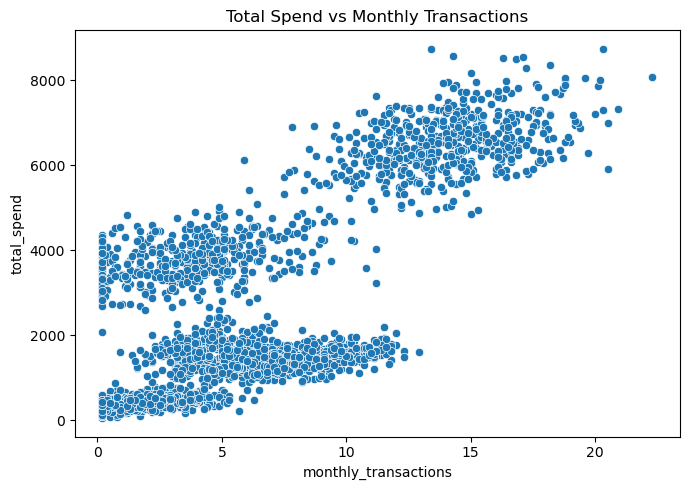

In [20]:
# Scatter: total_spend vs monthly_transactions
if "total_spend" in df.columns and "monthly_transactions" in df.columns:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=df,
        x="monthly_transactions",
        y="total_spend"
    )
    plt.title("Total Spend vs Monthly Transactions")
    plt.tight_layout()
    plt.show()

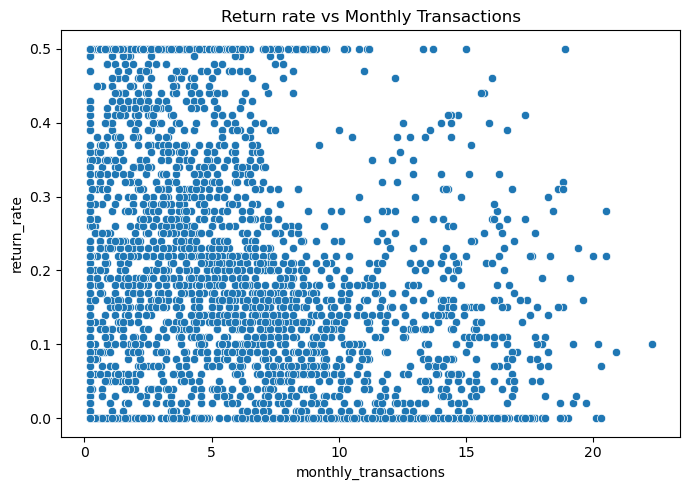

In [22]:
# Scatter: return_rate vs monthly_transactions
if "return_rate" in df.columns and "monthly_transactions" in df.columns:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=df,
        x="monthly_transactions",
        y="return_rate"
    )
    plt.title("Return rate vs Monthly Transactions")
    plt.tight_layout()
    plt.show()

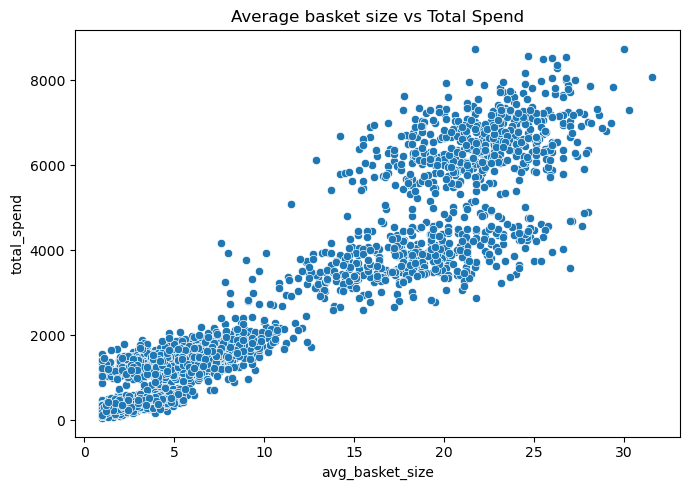

In [23]:
# Scatter: total_spend vs monthly_transactions
if "avg_basket_size" in df.columns and "total_spend" in df.columns:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=df,
        x="avg_basket_size",
        y="total_spend"
    )
    plt.title("Average basket size vs Total Spend")
    plt.tight_layout()
    plt.show()

## Section 3: Data Preprocessing

In [25]:
# Check for missing data
print(df.isnull().sum())

customer_id                0
monthly_transactions       0
avg_basket_size            0
total_spend                0
avg_session_duration       0
email_open_rate            0
product_views_per_visit    0
return_rate                0
customer_tenure_months     0
recency_days               0
dtype: int64


In [30]:
# Initialize scaler
scaler = StandardScaler()

# Fit + transform
scaled_data = scaler.fit_transform(num_df)
df_scaled = pd.DataFrame(scaled_data, columns=num_df.columns)
logger.info("Dataset scaled successfully")


INFO: Dataset scaled successfully


In [31]:
df_scaled.describe()

,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03,3.000000e+03
mean,1.290819e-16,-4.263256e-17,2.842171e-17,7.460699e-17,-8.526513e-17,4.973799e-17,-1.539509e-16,2.368476e-18,-4.263256e-17
std,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00,1.000167e+00
min,-1.216830e+00,-1.065978e+00,-1.030908e+00,-2.445025e+00,-1.038395e+00,-2.846642e+00,-1.145657e+00,-1.504629e+00,-1.632788e+00
25%,-8.189887e-01,-7.770313e-01,-8.257765e-01,-7.983336e-01,-1.038395e+00,-6.483828e-01,-8.991336e-01,-7.929123e-01,-8.031475e-01
50%,-2.117565e-01,-4.880849e-01,-4.053880e-01,-1.319818e-01,-2.427260e-01,2.414405e-02,-2.211934e-01,7.769579e-03,-2.223990e-01
75%,5.839270e-01,9.849136e-01,6.249629e-01,7.646276e-01,1.184799e+00,6.464824e-01,6.416396e-01,7.194868e-01,7.109468e-01
max,3.410697e+00,2.778266e+00,2.837726e+00,3.409102e+00,1.184799e+00,3.115760e+00,1.935889e+00,3.655320e+00,3.842841e+00


Since clustering algorithms are distance-based, all variables must follow the same scale. Therefore we apply StandardScaler to ensure each feature has mean = 0 and standard deviation = 1. This prevents variables with large ranges from dominating.

## Section 4: Hierarchical Clustering Analysis

In [33]:
# Compute linkage data
Z_single = linkage(df_scaled, method='single')
Z_complete = linkage(df_scaled, method='complete')
Z_average = linkage(df_scaled, method='average')
Z_ward = linkage(df_scaled, method='ward')

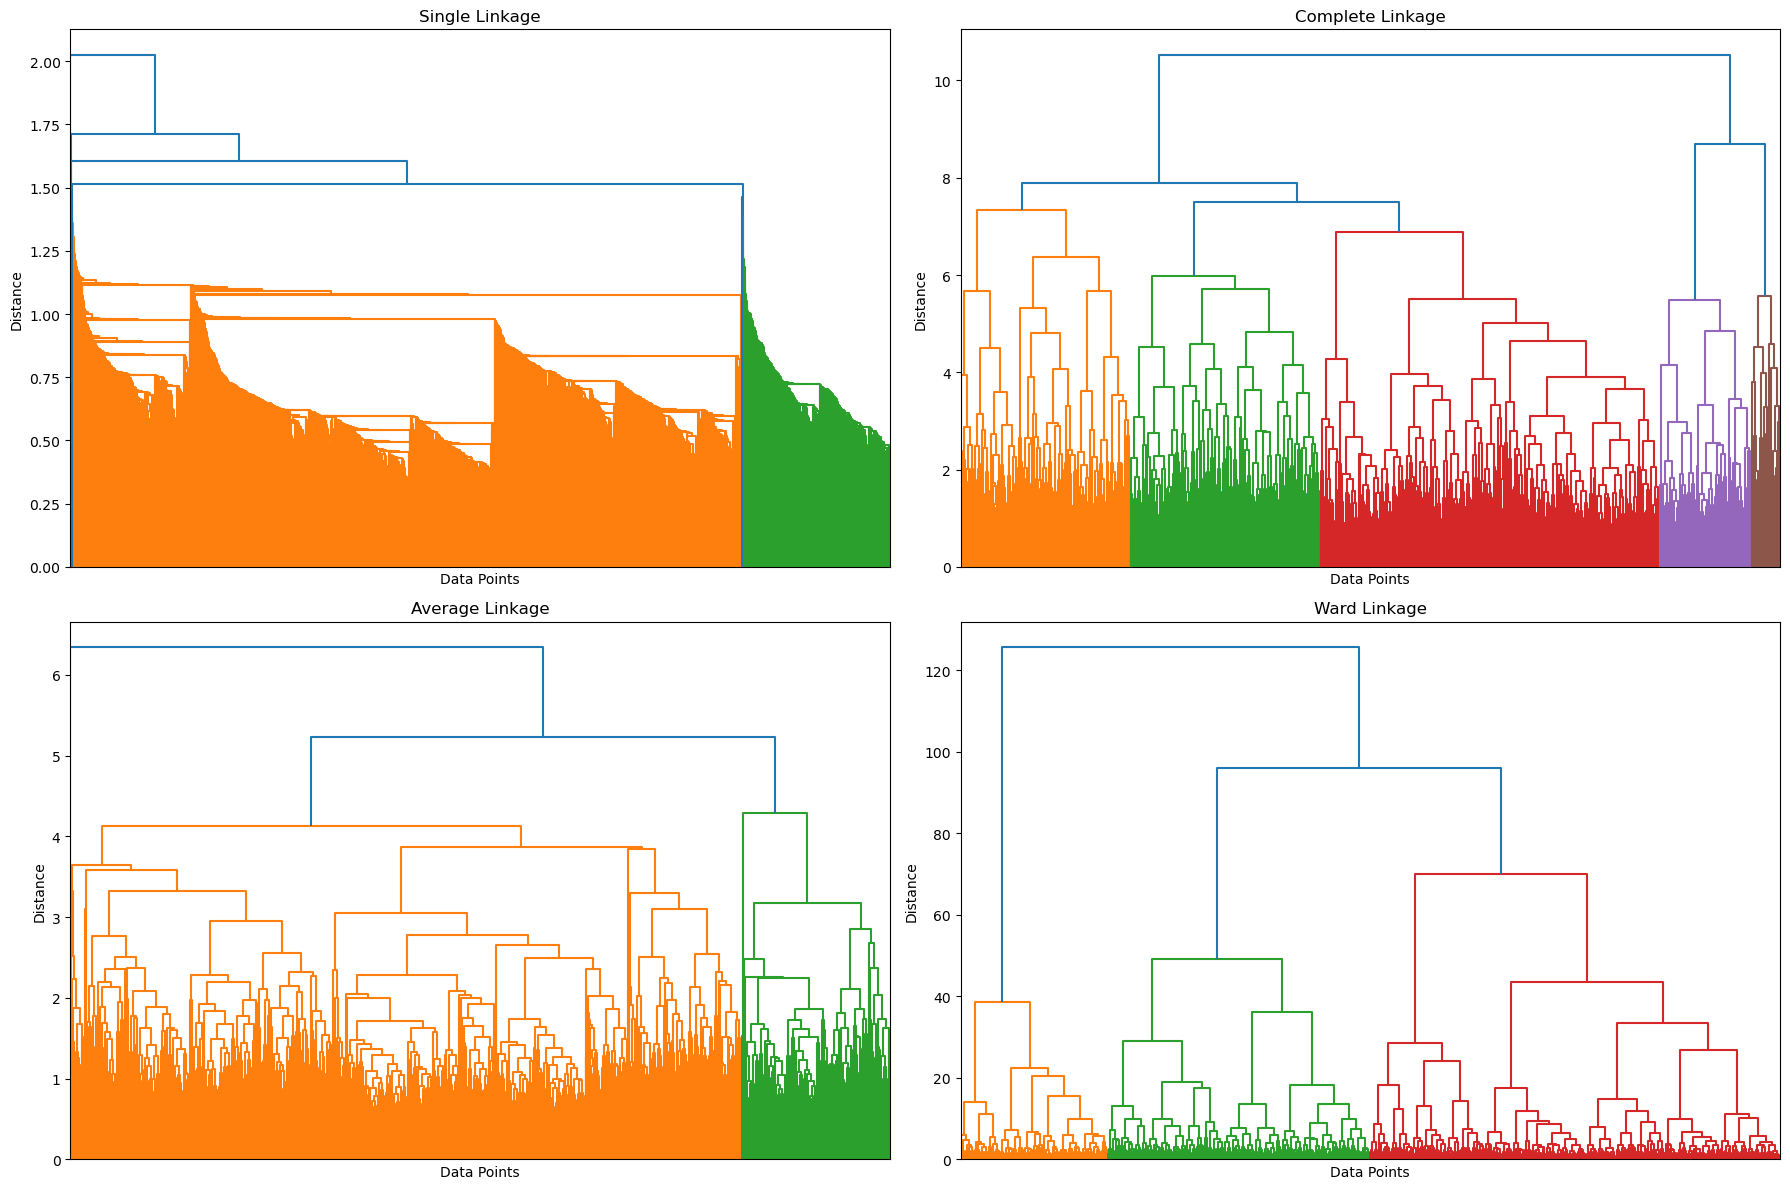

In [34]:
# Plot all the dendograms
plt.figure(figsize=(18, 12))

# Single linkage
plt.subplot(2, 2, 1)
dendrogram(Z_single, no_labels=True)
plt.title("Single Linkage")
plt.ylabel("Distance")

# Complete linkage
plt.subplot(2, 2, 2)
dendrogram(Z_complete, no_labels=True)
plt.title("Complete Linkage")
plt.ylabel("Distance")

# Average linkage
plt.subplot(2, 2, 3)
dendrogram(Z_average, no_labels=True)
plt.title("Average Linkage")
plt.ylabel("Distance")

# Ward linkage
plt.subplot(2, 2, 4)
dendrogram(Z_ward, no_labels=True)
plt.title("Ward Linkage")
plt.ylabel("Distance")

plt.tight_layout()
plt.show()

### Interpretation of Linkage Methods
The single linkage shows clear chaining, where  points are merged one by one at very low distances. This creates long chains instead of meaningful clusters, so it is not suitable for customer segmentation. Furthermore, the complete linkage produces tighter clusters than single linkage, but the dendrogram still looks noisy and does not show very clear separation between major groups. Average linkage still does not create strong, well-defined cluster boundaries. 

Ward linkage shows the clearest structure. There are high vertical jumps at the top of the dendrogram which indicates separated clusters. For that reasonm this method is the best in our case.

The chaining effect appears mostly in single linkage, where many points merge at very low distances.

## Section 5: Determining Optimal Number of Clusters (Hierarchical)

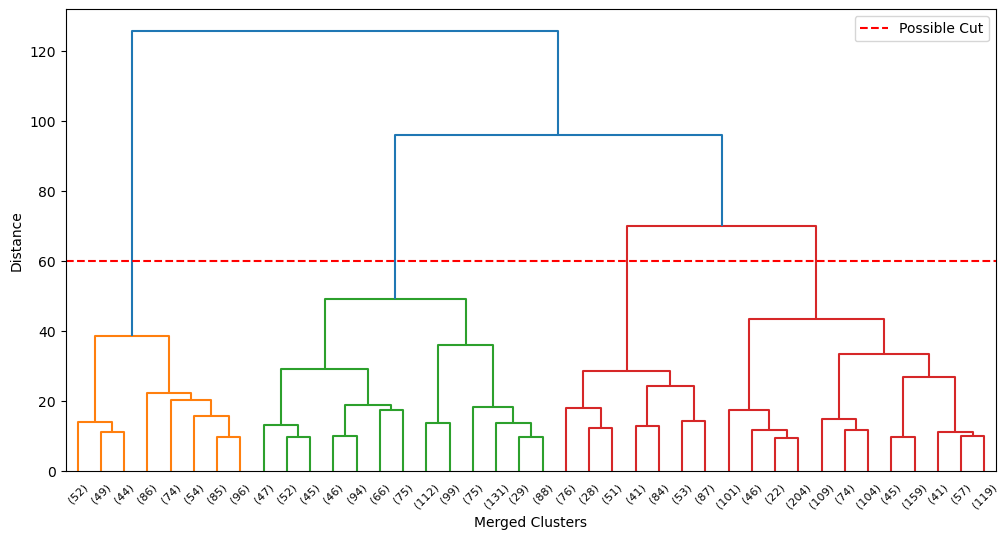

In [42]:
# Ward diagram with cut line
plt.figure(figsize=(12, 6))
dendrogram(Z_ward, truncate_mode="lastp", p=40)
plt.axhline(y=60, color='red', linestyle='--', label='Possible Cut')
plt.xlabel("Merged Clusters")
plt.ylabel("Distance")
plt.legend()
plt.show()

In [45]:
# Calculate the silhouette scores for k = 3,4,5,6
cluster_results = {}
for k in [3, 4, 5, 6]:
    labels = fcluster(Z_ward, k, criterion="maxclust")
    cluster_results[k] = labels
    
sscores = {}
for k, labels in cluster_results.items():
    score = silhouette_score(df_scaled, labels)
    sscores[k] = score

# Create a table
summary_df = pd.DataFrame({
    "k": list(sscores.keys()),
    "Silhouette Score": list(sscores.values())
})
summary_df.style.format({"Silhouette Score": "{:.4f}"})


,k,Silhouette Score
0,3,0.2948
1,4,0.3157
2,5,0.3003
3,6,0.2475


This means that k = 4 provides the best choice. Scores decrease for k = 5 and especially k = 6, indicating that splitting the
data into more clusters leads to less meaningful groupings.



## Section 6: K-Means Clustering - Elbow Method

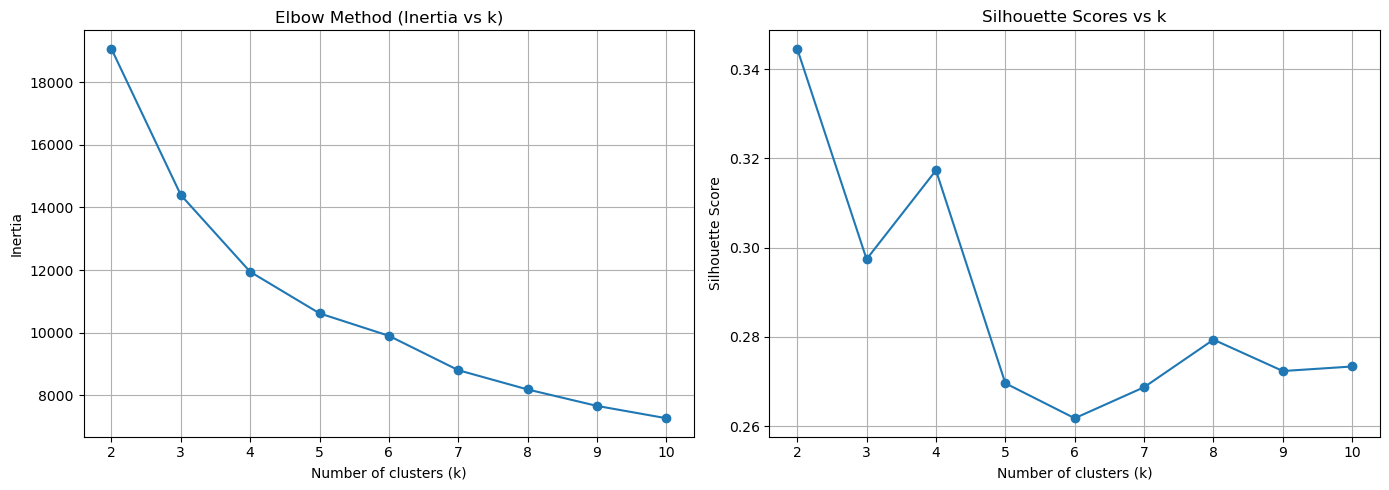

In [47]:
inertias = []
sscores_kmeans = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    
    inertias.append(kmeans.inertia_)
    sscores_kmeans.append(silhouette_score(df_scaled, labels))

# Plotting 1x2 subplot
plt.figure(figsize=(14, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(k_values, sscores_kmeans, marker='o')
plt.title("Silhouette Scores vs k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

The elbow plot shows that the inertia decreases fastest up to around k = 4, therafter the improvements become much smaller, indicating an elbow around 4. The silhouette scores also peak for k = 4, but also for k = 2, which would however result in weaker separation. So by using both methods together, 4 clusters is the best option. 

## Section 7: Final Cluster Selection

Based on both hierarchical clustering and K-means results, the most suitable number of clusters is k = 4. The Ward dendrogram shows a clear separation around three groups, but then the elbow plot flattens noticeably after k = 4, indicating diminishing improvements beyond this point. The silhouette scores also support k = 4, as it provides the strongest balance between cohesion and separation. 

## Section 8: Apply Final K-Means Model

In [54]:
# Fit final K-Means model
k = 4

# Fit KMeans on the standardized data
kmeans_final = KMeans(n_clusters=k, random_state=42)
final_labels = kmeans_final.fit_predict(df_scaled)

# Add cluster labels to the original dataframe
num_df["cluster"] = final_labels

# Calculate cluster sizes
cluster_counts = df["cluster"].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df)) * 100

print("Cluster Counts:")
print(cluster_counts)

print("\nCluster Percentages (%):")
print(cluster_percentages.round(3))

Cluster Counts:
cluster
0     525
1     929
2     433
3    1113
Name: count, dtype: int64

Cluster Percentages (%):
cluster
0    17.500
1    30.967
2    14.433
3    37.100
Name: count, dtype: float64


## Section 9: Cluster Profiling and Interpretation

Cluster Mean Profiles:


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
cluster,,,,,,,,,
0,14.073524,22.025714,6507.290648,45.918095,0.576210,43.008571,0.098990,26.220952,8.024762
1,1.683100,3.050161,422.620377,52.308719,0.374166,30.014532,0.274672,15.305705,35.592034
2,4.042494,18.173903,3875.935543,22.359122,0.449538,16.548499,0.244804,21.602771,19.840647
3,6.586972,5.560647,1450.947125,29.596855,0.437017,32.749236,0.129856,14.734052,14.530997


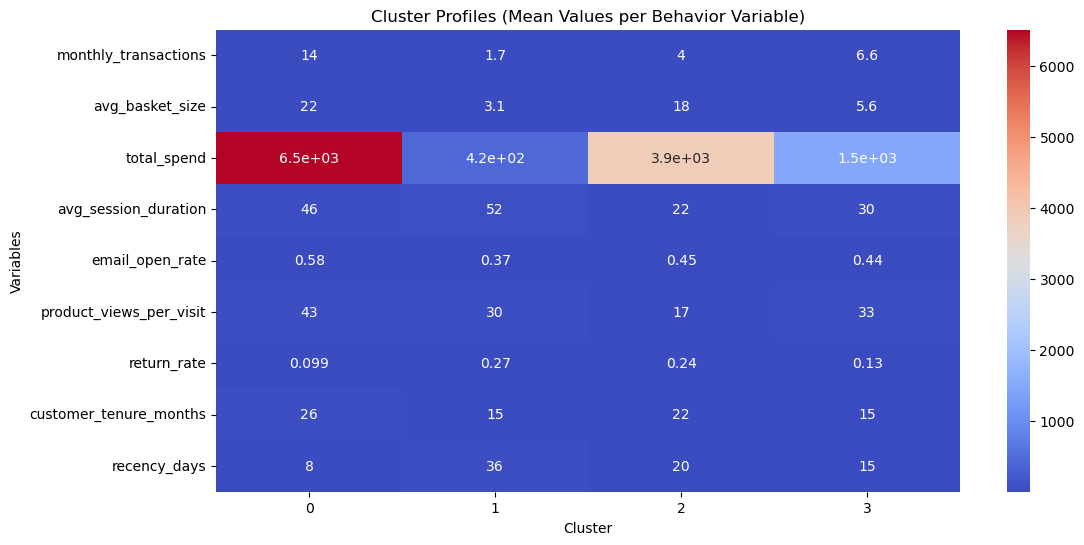

In [57]:
# Calculate cluster means
cluster_profile = num_df.groupby("cluster").mean()

print("Cluster Mean Profiles:")
display(cluster_profile)

# Create heatmap 
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile.T, cmap="coolwarm", annot=True)
plt.title("Mean Values per Variable")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.show()

- Cluster 0: **The High-value Frequent Shoppers(≈17.5%)**
Customers in this cluster shop very frequently and spend by far the most overall, with the highest total spend and large basket sizes. They also have the lowest return rates, showing strong satisfaction. Their recent activity and long tenure indicate that they are stable, loyal and high-value customers.

- Cluster 1: **The Low-Activity Window-shoppers(≈30.967%)**
These customers rarely make any purchases and spend very little overall, with the lowest basket sizes and the highest return rate among all clusters. Their recency score is very high, meaning many have not shopped in a long time. They show weak engagement based on the email open rate, but on the other hand they have a high session duration - meaning they browse a lot even if they don’t buy it.

- Cluster 2: **Luxury Occasional Shoppers (≈14.443%)**
This group has the second largest baskets but shops less frequently. Their engagement is average, and their return rate is somewhat high, suggesting they may be selective buyers. Their sessions are usually short, and they don’t view a lot of products, suggesting they are decisive in their shopping. 

- Cluster 3: **Budget-Conscious Regular Buyers (≈37.1%)**
These customers shop regularly but with small basket sizes and low total spending. Their engagement is average, and their return rate is low, suggesting they are consistent but low-value shoppers. 


## Section 10: Cluster Validation - Silhouette Analysis

Average Silhouette Score: 0.317


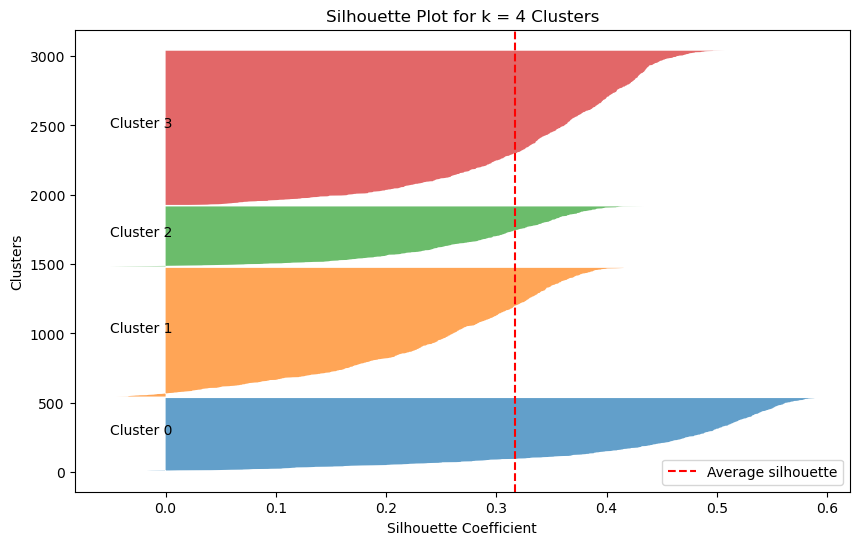

In [60]:
# Compute silhouette scores for each customer
sil_values = silhouette_samples(df_scaled, num_df["cluster"])

# Overall silhouette avg
sil_avg = silhouette_score(df_scaled, df["cluster"])
print("Average Silhouette Score:", round(sil_avg, 3))

# Prepare plot
plt.figure(figsize=(10, 6))

y_lower = 10
for cluster in sorted(df["cluster"].unique()):
    # Extract silhouette values for cluster
    c_sil = sil_values[num_df["cluster"] == cluster]
    c_sil.sort()
    size_c = c_sil.shape[0]
    y_upper = y_lower + size_c
    
    # Plot the silhouette values for cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil, alpha=0.7)
    plt.text(-0.05, y_lower + size_c / 2, f"Cluster {cluster}")
    
    y_lower = y_upper + 10

plt.axvline(sil_avg, color="red", linestyle="--", label="Average silhouette")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Clusters")
plt.title("Silhouette Plot for k = 4 Clusters")
plt.legend()
plt.show()

The silhouette plot shows that clusters 0 and 3 are the clearest groups. Most customers in these clusters have fairly high silhouette values, meaning they fit well inside their cluster and are different from customers in other clusters. Cluster 1 is okay but not as strong, and cluster 2 is the weakest because many of its customers have scores close to zero, meaning they are not very clearly separated from other clusters. Only a few customers have negative values, so very few are placed in a cluster that doesn’t really match them. Overall, this suggests that choosing 4 clusters works well and gives a reasonable and understandable grouping of the customers.

## Section 11: Cluster Visualization (PCA Projection)

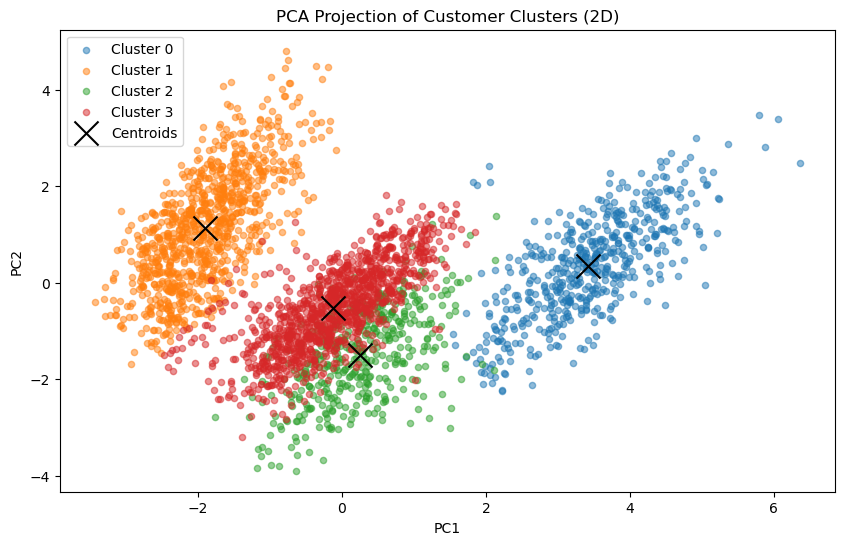

PC1 explains: 41.01%
PC2 explains: 20.97%
Total variance explained by PC1 + PC2: 61.98%


In [66]:
# Apply PCA to the standardized data
pca = PCA(n_components=2)
pcs = pca.fit_transform(df_scaled)

# Add PCA components to df for plotting 
df["PC1"] = pcs[:, 0]
df["PC2"] = pcs[:, 1]



# Plot PCA scatter with clusters
plt.figure(figsize=(10, 6))

for cluster in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], s=20, alpha=0.5, label=f"Cluster {cluster}")

# Plot centroids
centroids = df.groupby("cluster")[["PC1", "PC2"]].mean()
plt.scatter(centroids["PC1"],centroids["PC2"],s=300,c="black",marker="x",label="Centroids")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Customer Clusters (2D)")
plt.legend()
plt.show()

# Print the variance explained
var_exp = pca.explained_variance_ratio_
print(f"PC1 explains: {var_exp[0]*100:.2f}%")
print(f"PC2 explains: {var_exp[1]*100:.2f}%")
print(f"Total variance explained by PC1 + PC2: {var_exp.sum()*100:.2f}%")

This PCA plot shows the clusters in only two dimensions, but the real clustering was done using all nine original variables. That means the plot is just a simplified projection of the data, and some clusters may look closer or more overlapping here than they actually are in the full 9-dimensional space.

## Section 12: Technical Conclusion

The results show that four clusters work best for this dataset. The K-means elbow method and the silhouette scores confirmed that k = 4 gives clear and stable groups. Most customers fit well into their clusters, but there is a few borderline cases. The four groups also makes sense in terms of behavior: where Cluster 0 includes high-spending, very active shoppers, Cluster 1 contains low-spend customers who shop and engage little, Cluster 2 includes customers with large baskets but lower engagement and Cluster 3 represents steady shoppers.